In [1]:
# Various imports

%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths, epi_reg

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import os.path as op
from mne.datasets import sample

# Scattered import found throughout the labs

from nilearn.image import concat_imgs
from nipype.interfaces.fsl import FAST
import subprocess

Gtk-Message: 01:39:34.260: Failed to load module "canberra-gtk-module"


In [2]:
# Open FSL eyes

fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

01:39:43: Debug: Adding duplicate image handler for 'Windows bitmap file'
01:39:43: Debug: Adding duplicate animation handler for '1' type
01:39:43: Debug: Adding duplicate animation handler for '2' type
01:39:44: Debug: Adding duplicate image handler for 'Windows bitmap file'
01:39:44: Debug: Adding duplicate animation handler for '1' type
01:39:44: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:58441): Gtk-CRITICAL **: 01:39:44.387: gtk_window_resize: assertion 'height > 0' failed


In [3]:
# Functions to download dataset

def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

In [4]:
# Download dataset

dataset_fmap = 'ds000171'
subject_fmap = '001'

# Main directory
bids_root = op.join(op.dirname(sample.data_path()), dataset_fmap)

# Paths for functional and anatomical data
func_path = op.join(bids_root, 'sub-control01', 'func')
anat_path = op.join(bids_root, 'sub-control01', 'anat')
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

# Create directories for func and anat
mkdir_no_exist(bids_root)
mkdir_no_exist(op.join(bids_root, 'sub-control01'))
mkdir_no_exist(func_path)
mkdir_no_exist(anat_path)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)

# List of functional files to download
file_list = [
    'sub-control01_task-music_run-1_bold.nii.gz',
    'sub-control01_task-music_run-1_events.tsv',
    'sub-control01_task-music_run-2_bold.nii.gz',
    'sub-control01_task-music_run-2_events.tsv',
    'sub-control01_task-music_run-3_bold.nii.gz',
    'sub-control01_task-music_run-3_events.tsv',
]

file_types = ['func'] * len(file_list)
save_dirs = [func_path] * len(file_list)


direct_file_download_open_neuro(file_list=file_list, 
                                 file_types=file_types, 
                                 dataset_id=dataset_fmap, 
                                 dataset_version='00001', 
                                 save_dirs=save_dirs)

# List of anatomical files to download
anat_file_list = ['sub-control01_T1w.nii.gz']

# For the anac files, define their types and save directories
anat_file_types = ['anat'] * len(anat_file_list)
anat_save_dirs = [anat_path] * len(anat_file_list)

# Download anatomical files
direct_file_download_open_neuro(file_list=anat_file_list, 
                                 file_types=anat_file_types, 
                                 dataset_id=dataset_fmap, 
                                 dataset_version='00001', 
                                 save_dirs=anat_save_dirs)

otherfiles_list = [
    'CHANGES',
    'README',
    'dataset_description.json',
    'T1w.json',
    'participants.tsv',
    'task-music_bold.json',
    'task-nonmusic_bold.json'
]

for filename in otherfiles_list:
    # Construct the download link for these files
    download_link = f'https://openneuro.org/crn/datasets/{dataset_fmap}/snapshots/00001/files/{filename}'
    print(f'Attempting download from: {download_link}')
    # Download the file without specifying file_type
    download_url(download_link, op.join(bids_root, filename))
    print('Downloaded:', filename)

Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-1_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-1_bold.nii.gz: 35.5MB [00:03, 9.05MB/s]                


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-1_events.tsv


sub-control01:func:sub-control01_task-music_run-1_events.tsv: 8.19kB [00:00, 24.0kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-2_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-2_bold.nii.gz: 35.5MB [00:02, 13.0MB/s]                  


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-2_events.tsv


sub-control01:func:sub-control01_task-music_run-2_events.tsv: 8.19kB [00:00, 12.3kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-3_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-3_bold.nii.gz: 35.5MB [00:02, 13.0MB/s]                  


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-3_events.tsv


sub-control01:func:sub-control01_task-music_run-3_events.tsv: 8.19kB [00:00, 12.7kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:anat:sub-control01_T1w.nii.gz


sub-control01:anat:sub-control01_T1w.nii.gz: 9.21MB [00:06, 1.53MB/s]                


Ok
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/CHANGES


CHANGES: 8.19kB [00:00, 16.0kB/s]


Downloaded: CHANGES
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/README


README: 8.19kB [00:00, 14.4kB/s]


Downloaded: README
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/dataset_description.json


dataset_description.json: 8.19kB [00:00, 13.4kB/s]


Downloaded: dataset_description.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/T1w.json


T1w.json: 8.19kB [00:00, 15.2kB/s]


Downloaded: T1w.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/participants.tsv


participants.tsv: 8.19kB [00:00, 14.6kB/s]


Downloaded: participants.tsv
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-music_bold.json


task-music_bold.json: 8.19kB [00:00, 14.9kB/s]


Downloaded: task-music_bold.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-nonmusic_bold.json


task-nonmusic_bold.json: 8.19kB [00:00, 15.5kB/s]

Downloaded: task-nonmusic_bold.json


In [5]:
# Data standardization

# Load the individual fMRI runs
run1 = nib.load(op.join(func_path, 'sub-control01_task-music_run-1_bold.nii.gz'))
run2 = nib.load(op.join(func_path, 'sub-control01_task-music_run-2_bold.nii.gz'))
run3 = nib.load(op.join(func_path, 'sub-control01_task-music_run-3_bold.nii.gz'))

concatenated_file_path = '/home/jovyan/mne_data/ds000171/sub-control01/func/concatenated_task_music_bold.nii.gz'

def standardize_img(img):
    data = img.get_fdata()
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    return nib.Nifti1Image(standardized_data, img.affine)

run1_standardized = standardize_img(run1)
run2_standardized = standardize_img(run2)
run3_standardized = standardize_img(run3)

concatenated_img = concat_imgs([run1_standardized, run2_standardized, run3_standardized])

nib.save(concatenated_img, concatenated_file_path)

print("Concatenation complete and saved as 'concatenated_task_music_bold.nii.gz'.")

Concatenation complete and saved as 'concatenated_task_music_bold.nii.gz'.


In [6]:
# Display standardized data

fsleyesDisplay.resetOverlays()

if op.exists(concatenated_file_path):
    fsleyesDisplay.load(concatenated_file_path)
    
    print("Loaded:", concatenated_file_path)
else:
    print("File does not exist at the specified path.")


(ipykernel_launcher.py:58441): Gdk-WARNING **: 01:40:49.529: gdkdrawable-x11.c:952 drawable is not a pixmap or window


Loaded: /home/jovyan/mne_data/ds000171/sub-control01/func/concatenated_task_music_bold.nii.gz


In [7]:
# BET

def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Perform skull-stripping on the T1w anatomical image for the specified subject.
        Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = f'sub-{subject_id}'
    anatomical_path = op.join(bids_root, subject, 'anat', f'{subject}_T1w.nii.gz')
    
    betted_brain_path = op.join(preproc_root, subject, 'anat', f'{subject}_T1w')

    mkdir_no_exist(op.join(preproc_root, subject, 'anat'))
    
    os.system(f'bet {anatomical_path} {betted_brain_path} -m {"-R" if robust else ""}')
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')

get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)


Done with BET.


In [8]:
# Display BET

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concatenated_file_path)
fsleyesDisplay.load(resulting_mask_path)

In [9]:
# Actually extract the brain

def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """
    Parameters
    ----------
    img_path: str
        Path to the input image that needs to be masked.
    mask_path: str
        Path to the mask image.
    masked_img_path: str
        Path where the masked output image will be saved.
    """
    # Execute the fslmaths command with the -mas option
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    print(f"Masked image saved at: {masked_img_path}")

# Define paths based on your dataset structure
subject_id = "control01"
anatomical_path = op.join(bids_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w.nii.gz')  # Original brain
betted_brain_path = op.join(preproc_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w.nii.gz')  # Skull-stripped brain
resulting_mask_path = op.join(preproc_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w_mask.nii.gz')  # The mask

apply_fsl_math_approach(betted_brain_path, resulting_mask_path, anatomical_path)


Masked image saved at: /home/jovyan/mne_data/ds000171/sub-control01/anat/sub-control01_T1w.nii.gz


In [10]:
# Display the extracted brain

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

In [11]:
# FAST segmentation

subject = f'sub-{subject_id}'
anatomical_path = op.join(bids_root, subject, 'anat', f'{subject}_T1w.nii.gz')
bet_path = op.join(preproc_root, subject, 'anat', f'{subject}_T1w')

fast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)

[os.remove(f) for f in glob.glob(op.join(preproc_root, subject, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, subject, 'anat', f'{subject}_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)
print("FAST segmentation complete.")

FAST segmentation complete.


Text(0, 0.5, 'Mean voxel intensity')

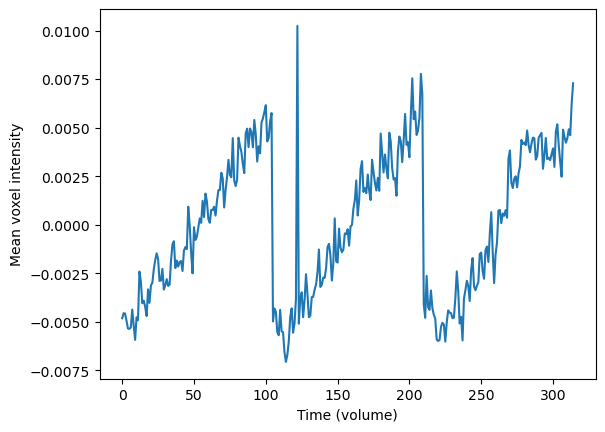

In [22]:
# Check the contrast
# looking at the y-axis I guess we are fine (?)
# I checked there are 315 volumes
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(bids_root, 'sub-control01', 'func', 'concatenated_task_music_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [24]:
# Motion Correction

from fsl.wrappers import mcflirt
import subprocess
dataset_id = 'ds000171'
subject = '01' 

mkdir_no_exist(os.path.join(preproc_root, 'sub-control01', 'func'))

path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco.nii.gz')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In [25]:
# Show motion correction

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [27]:
# Coregistration with epi_reg (no idea if needed here)

epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco')
whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_bbr')
ref_vol_name =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco_vol_middle')

use_single_vol = True

if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    fslroi(epi_target, ref_vol_name, str(182), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])

Image Exception : #5 :: Out of Bounds (time index)
Out of Bounds (time index)


Running FAST segmentation
FLIRT pre-alignment
Running BBR


Image Exception : #63 :: No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_vol_middle
Image Exception : #22 :: Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_vol_middle
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_vol_middle
Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_vol_middle
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_vol_middle
Image Exception : #63 :: No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_m

In [28]:
# Clean up needed after epi_reg

def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)
cleanup_epi_reg(op.join(preproc_root, 'sub-001', 'func'))

In [30]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- task-nonmusic_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-001/
|------------ func/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|------------ func/
|--------------- sub-control01_task-music_run-1_bold_bbr_fast_wmedge.nii.gz
|--------------- sub-control01_task-music_run-1_bold_bbr_fast_wmseg.nii.gz
|--------------- sub-control01_task-music_run-1_bold_moco.nii.gz
|--------------- sub-control01_task-music_run-1_bold_moco.nii.gz.p

In [38]:
# Smoothing

output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco.nii.gz')

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])



CompletedProcess(args=['fslmaths', '/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco.nii.gz', '-s', '2.547987090198743', '/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco.nii.gz_smoothed-6mm'], returncode=0)

In [39]:
# See smoothing

fsleyesDisplay.load(output_path + '_smoothed-6mm')